
# Modelo de predicción del precio del banano

Ecuador se situa como uno de los top 5 países con exportaciones más altas de banano.

Sin embargo, los productores y exportadores ecuatorianos negocian con desventaja porque no cuentan con información en tiempo real sobre el precio variable de comercialización.
Esta brecha genera incertidumbre, limita la planificación logística y reduce la capacidad de reacción frente a cambios de clima, logística o demanda internacional.

El problema es claro: la falta de pronósticos confiables y actualizados restringe la competitividad del sector bananero en los mercados globales.

|<img src="https://www.freshplaza.com/remote/https/agfstorage.blob.core.windows.net/misc/FP_com/2023/12/19/acorbanec7.jpg?preset=ContentFullSmall" width="500" align="center">|
|:--:|
| <b>Banana: La fruta más importante del país. Imagen: [FreshPlaza](https://www.freshplaza.com/north-america/article/9587090/ecuador-looking-to-expand-production-with-fta-s-coming-into-full-force/) </b>|


**Meta**: Desarrollar un modelo de inteligencia artificial híbrido, que complemente los modelos tradicionales (ARIMA, SARIMA, ETS), para fortalecer el poder de negociación de los exportadores.

Este notebook realiza el Análisis Exploratorio de Datos para obtener insights significativos sobre el dataset a usar en el proyecto.


# 1. Carga y Exploración Inicial

**Procedencia de los datos:** Observatorio Estadístico de Banano. Datos recolectados de un panel de 10 productores y 10 exportadores, con licencia restringida a suscriptores de la plataforma oficial https://observatoriobanano.com/precios.

**Descripción técnica:** Serie temporal semanal desde 2017 hasta 2025. Datos en formato Excel/CSV, con estructura organizada por semana y precio promedio ponderado.

**Cargar librerías**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
import io

from scipy.stats import zscore
import numpy as np

from scipy.stats import shapiro, kstest, skew, kurtosis, pearsonr, spearmanr

**Importar los datos del dataset**

In [35]:

uploaded = files.upload()
path = 'precio_ecuador.xlsx'
df = pd.read_excel(path)
df.head()


Saving precio_ecuador.xlsx to precio_ecuador.xlsx


,Año,Semana,Precio
0,2017,1,3.3
1,2017,2,3.4
2,2017,3,5.6
3,2017,4,7.6
4,2017,5,7.2


**Mostrar primeras y ultimas filas y estadísticas descriptivas**

In [36]:
# Visualizacion de los primeros registros
print("Primeras 5 filas del dataset:")
print(df.head())

# Visualización de ultimos registros
print("\nUltimas 5 filas del dataset:")
print(df.tail())

# Información general
print("\nInformación general del dataset:")
print(df.info())

# Explorar estadísticas descriptivas
print("\nEstadísticas descriptivas del dataset:")
print(df.describe())

Primeras 5 filas del dataset:
    Año  Semana  Precio
0  2017       1     3.3
1  2017       2     3.4
2  2017       3     5.6
3  2017       4     7.6
4  2017       5     7.2

Ultimas 5 filas del dataset:
      Año  Semana  Precio
448  2025      33    9.98
449  2025      34   10.37
450  2025      35   11.02
451  2025      36   11.96
452  2025      37   12.37

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Año     453 non-null    int64  
 1   Semana  453 non-null    int64  
 2   Precio  453 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 10.7 KB
None

Estadísticas descriptivas del dataset:
               Año      Semana      Precio
count   453.000000  453.000000  453.000000
mean   2020.867550   25.887417    6.833512
std       2.520734   14.861697    2.606104
min    2017.000000    1.000000    1.800000
25%   

**Calcular medidas de tendencia central**

In [37]:
# Calcular media, mediana y moda
media = df['Precio'].mean()
mediana = df['Precio'].median()
moda = df['Precio'].mode()[0]

print(f"Media: {media}, Mediana: {mediana}, Moda: {moda}")

# Función para interpretar las diferencias
def interpretar_tendencia_central(media, mediana, moda, tolerancia=0.05):
    """
    Interpreta las diferencias entre medidas de tendencia central

    Args:
        media: Media aritmética
        mediana: Mediana
        moda: Moda
        tolerancia: Porcentaje de tolerancia para considerar valores "similares"
    """

    # Calcular diferencias relativas
    rango_valor = max(media, mediana, moda) - min(media, mediana, moda)

    # Si el rango es muy pequeño, consideramos que son similares
    if rango_valor / max(media, mediana, moda) <= tolerancia:
        return "simétrica"

    # Comparar media y mediana para determinar asimetría
    if media > mediana:
        if abs(media - mediana) / mediana > tolerancia:
            return "sesgo_positivo"
        else:
            return "ligeramente_asimétrica_positiva"
    elif media < mediana:
        if abs(media - mediana) / mediana > tolerancia:
            return "sesgo_negativo"
        else:
            return "ligeramente_asimétrica_negativa"
    else:
        return "simétrica"

# Interpretar los resultados
tipo_distribucion = interpretar_tendencia_central(media, mediana, moda)

print("\nINTERPRETACIÓN DE LAS DIFERENCIAS:")
print("=" * 50)

if tipo_distribucion == "simétrica":
    print("📊 DISTRIBUCIÓN SIMÉTRICA")
    print("• Las tres medidas son muy similares")
    print("• Los datos están equilibradamente distribuidos")
    print("• No hay valores extremos significativos")
    print("• La media es una buena representación del conjunto")

elif tipo_distribucion == "sesgo_positivo":
    print("📈 DISTRIBUCIÓN CON SESGO POSITIVO (Cola derecha)")
    print(f"• Media ({media:.2f}) > Mediana ({mediana:.2f})")
    print("• Hay valores altos que 'jalan' la media hacia arriba")
    print("• La mayoría de los datos se concentran en valores menores")
    print("• Posibles valores atípicos altos")
    print("• La mediana representa mejor el valor típico")

elif tipo_distribucion == "sesgo_negativo":
    print("📉 DISTRIBUCIÓN CON SESGO NEGATIVO (Cola izquierda)")
    print(f"• Media ({media:.2f}) < Mediana ({mediana:.2f})")
    print("• Hay valores bajos que 'jalan' la media hacia abajo")
    print("• La mayoría de los datos se concentran en valores mayores")
    print("• Posibles valores atípicos bajos")
    print("• La mediana representa mejor el valor típico")

elif "ligeramente" in tipo_distribucion:
    if "positiva" in tipo_distribucion:
        print("📊 DISTRIBUCIÓN LIGERAMENTE ASIMÉTRICA POSITIVA")
        print("• Ligera tendencia hacia valores altos")
    else:
        print("📊 DISTRIBUCIÓN LIGERAMENTE ASIMÉTRICA NEGATIVA")
        print("• Ligera tendencia hacia valores bajos")
    print("• Las diferencias son pequeñas")
    print("• Cualquier medida de tendencia central es representativa")

print("\n" + "=" * 50)

# Análisis adicional de la moda
print("ANÁLISIS DE LA MODA:")
print("-" * 20)

diferencia_media_moda = abs(media - moda)
diferencia_mediana_moda = abs(mediana - moda)

if diferencia_media_moda < diferencia_mediana_moda:
    print(f"• La moda ({moda:.2f}) está más cerca de la media")
    if diferencia_media_moda / media <= 0.1:
        print("• El valor más frecuente coincide con la tendencia general")
    else:
        print("• El valor más frecuente difiere de la tendencia general")
else:
    print(f"• La moda ({moda:.2f}) está más cerca de la mediana")
    if diferencia_mediana_moda / mediana <= 0.1:
        print("• El valor más frecuente coincide con el valor central")
    else:
        print("• El valor más frecuente difiere del valor central")

# Recomendación sobre qué medida usar
print("\n" + "=" * 50)
print("RECOMENDACIÓN:")
print("-" * 15)

if tipo_distribucion == "simétrica":
    print("✅ Usar preferentemente la MEDIA (todas son equivalentes)")
elif "sesgo" in tipo_distribucion:
    print("✅ Usar preferentemente la MEDIANA (menos afectada por extremos)")
    print("⚠️  La media puede ser engañosa debido a los valores extremos")
else:
    print("✅ Cualquier medida es apropiada (diferencias mínimas)")

# Estadísticas adicionales para contexto
print(f"\nRango de valores: {df['Precio'].min():.2f} - {df['Precio'].max():.2f}")
print(f"Desviación estándar: {df['Precio'].std():.2f}")
print(f"Coeficiente de variación: {(df['Precio'].std()/df['Precio'].mean())*100:.1f}%")

Media: 6.833511510564491, Mediana: 6.5, Moda: 2.0

INTERPRETACIÓN DE LAS DIFERENCIAS:
📈 DISTRIBUCIÓN CON SESGO POSITIVO (Cola derecha)
• Media (6.83) > Mediana (6.50)
• Hay valores altos que 'jalan' la media hacia arriba
• La mayoría de los datos se concentran en valores menores
• Posibles valores atípicos altos
• La mediana representa mejor el valor típico

ANÁLISIS DE LA MODA:
--------------------
• La moda (2.00) está más cerca de la mediana
• El valor más frecuente difiere del valor central

RECOMENDACIÓN:
---------------
✅ Usar preferentemente la MEDIANA (menos afectada por extremos)
⚠️  La media puede ser engañosa debido a los valores extremos

Rango de valores: 1.80 - 15.00
Desviación estándar: 2.61
Coeficiente de variación: 38.1%


**Calcular medidas de dispersión**

In [38]:
# Calcular rango, varianza y desviación
rango = df['Precio'].max() - df['Precio'].min()
varianza = df['Precio'].var()
desviacion = df['Precio'].std()

print(f"Rango: {rango}, Varianza: {varianza}, Desviación Estándar: {desviacion}")

# Calcular el coeficiente de variación para 'Precio'
# CV = (Desviación Estándar / Media) * 100
cv_precio = (df['Precio'].std() / df['Precio'].mean()) * 100

print(f"\nCoeficiente de Variación para 'Precio': {cv_precio:.2f}%")

# Interpretación del Coeficiente de Variación (regla general)
# CV < 10%: Baja variabilidad (datos muy consistentes)
# 10% <= CV < 30%: Variabilidad moderada
# CV >= 30%: Alta variabilidad (datos dispersos)

print("\nInterpretación del Coeficiente de Variación:")
if cv_precio < 10:
    print("  -> Baja variabilidad: Los precios son muy consistentes alrededor de la media.")
elif 10 <= cv_precio < 30:
    print("  -> Variabilidad moderada: Hay una dispersión razonable en los precios en relación con la media.")
else:
    print("  -> Alta variabilidad: Existe una dispersión significativa en los precios en relación con la media.")

Rango: 13.2, Varianza: 6.7917806151685705, Desviación Estándar: 2.6061044904547805

Coeficiente de Variación para 'Precio': 38.14%

Interpretación del Coeficiente de Variación:
  -> Alta variabilidad: Existe una dispersión significativa en los precios en relación con la media.


# 2. Análisis Univariado

**Generar Histogramas**

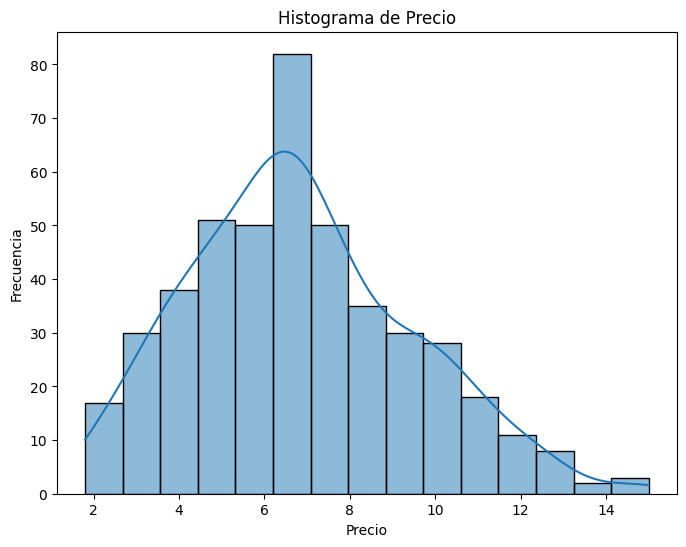

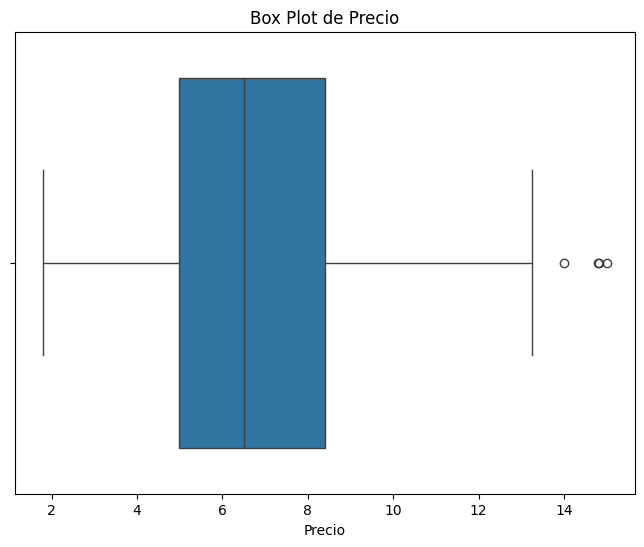


Estadísticas de distribución para 'Precio':
count    453.000000
mean       6.833512
std        2.606104
min        1.800000
25%        4.983333
50%        6.500000
75%        8.410000
max       15.000000
Name: Precio, dtype: float64

Identificación de Outliers para 'Precio' (usando IQR):
Primer Cuartil (Q1): 4.98
Tercer Cuartil (Q3): 8.41
Rango Intercuartílico (IQR): 3.43
Límite Inferior para Outliers: -0.16
Límite Superior para Outliers: 13.55

Outliers encontrados:


,Año,Semana,Precio
56,2018,5,14.00
57,2018,6,15.00
58,2018,7,14.83
59,2018,8,14.80


In [39]:


# Histograma de 'Precio'
plt.figure(figsize=(8, 6))
sns.histplot(df['Precio'].dropna(), kde=True)
plt.title('Histograma de Precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

# Box plot de 'Precio'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Precio'].dropna())
plt.title('Box Plot de Precio')
plt.xlabel('Precio')
plt.show()

# Estadísticas de distribución para 'Precio'
print("\nEstadísticas de distribución para 'Precio':")
print(df['Precio'].describe())

# Identificación de outliers utilizando el rango intercuartílico (IQR)
Q1 = df['Precio'].quantile(0.25)
Q3 = df['Precio'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Precio'] < limite_inferior) | (df['Precio'] > limite_superior)]

print(f"\nIdentificación de Outliers para 'Precio' (usando IQR):")
print(f"Primer Cuartil (Q1): {Q1:.2f}")
print(f"Tercer Cuartil (Q3): {Q3:.2f}")
print(f"Rango Intercuartílico (IQR): {IQR:.2f}")
print(f"Límite Inferior para Outliers: {limite_inferior:.2f}")
print(f"Límite Superior para Outliers: {limite_superior:.2f}")

if not outliers.empty:
    print("\nOutliers encontrados:")
    display(outliers)
else:
    print("\nNo se encontraron outliers.")

In [40]:
datos_normales = df[(df['Precio'] >= limite_inferior) & (df['Precio'] <= limite_superior)]
print(f"\n--- Impacto de Outliers ---")
print(f"Media CON outliers: {df['Precio'].mean():.2f}")
print(f"Media SIN outliers: {datos_normales['Precio'].mean():.2f}")
print(f"Mediana (robusta): {df['Precio'].median():.2f}")


--- Impacto de Outliers ---
Media CON outliers: 6.83
Media SIN outliers: 6.76
Mediana (robusta): 6.50


**Análisis de distribuición**

In [51]:
# Análisis de distribución para 'Precio'
print("--- Análisis de Distribución para 'Precio' ---")

# Normalidad - Shapiro-Wilk test (para sample size < 5000)
if len(df['Precio'].dropna()) < 5000:
    shapiro_test_stat, shapiro_p_value = shapiro(df['Precio'].dropna())
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test_stat:.3f}, P-value={shapiro_p_value:.3f}")
    if shapiro_p_value > 0.05:
        print("  -> La distribución de 'Precio' parece normal (no se rechaza H0).")
    else:
        print("  -> La distribución de 'Precio' no parece normal (se rechaza H0).")

# Normalidad - Kolmogorov-Smirnov test (more general)
# Need to specify the distribution to test against, e.g., 'norm' for normal
# kstest_test_stat, kstest_p_value = kstest(df['Precio'].dropna(), 'norm')
# print(f"Kolmogorov-Smirnov Test: Statistic={kstest_test_stat:.3f}, P-value={kstest_p_value:.3f}")
# if kstest_p_value > 0.05:
#     print("  -> La distribución de 'Precio' parece normal (no se rechaza H0).")
# else:
#     print("  -> La distribución de 'Precio' no parece normal (se rechaza H0).")


# Asimetría y curtosis
skewness_precio = skew(df['Precio'].dropna())
kurtosis_precio = kurtosis(df['Precio'].dropna())
print(f"\nAsimetría (Skewness) de 'Precio': {skewness_precio:.3f}")
print(f"Curtosis de 'Precio': {kurtosis_precio:.3f}")
if abs(skewness_precio) < 0.5 and abs(kurtosis_precio) < 0.5:
    print("  -> La distribución de 'Precio' es relativamente simétrica y mesocúrtica.")
elif abs(skewness_precio) >= 0.5:
    print(f"  -> La distribución de 'Precio' es asimétrica ({'positiva' if skewness_precio > 0 else 'negativa'}).")
elif abs(kurtosis_precio) >= 0.5:
     print(f"  -> La distribución de 'Precio' tiene colas pesadas o ligeras ({'leptocúrtica' if kurtosis_precio > 0 else 'platocúrtica'}).")


--- Análisis de Distribución para 'Precio' ---
Shapiro-Wilk Test: Statistic=0.982, P-value=0.000
  -> La distribución de 'Precio' no parece normal (se rechaza H0).

Asimetría (Skewness) de 'Precio': 0.432
Curtosis de 'Precio': -0.134
  -> La distribución de 'Precio' es relativamente simétrica y mesocúrtica.


# 3. Analisis Bivariado y 4. Analisis Multivariado

De manera preliminar se evaluó qué conjunto de variables ofrecía la mejor capacidad predictiva semanal del precio de la caja de banano. Para ello, se compararon múltiples configuraciones y algoritmos manteniendo criterios homogéneos de evaluación (RMSE, MAE y MAPE). Los resultados empíricos muestran de forma consistente que el modelo univariado con el precio rezagado en cinco semanas supera con holgura a cualquier configuración multivariada probada. En el escenario univariado (Precio con 5 lags), los mejores modelos (p. ej., SVR, LSTM y regresión lineal) alcanzaron MAPE ≈ 14–15% (SVR 14.53%, LSTM 14.76%, Linear 14.60%). En contraste, al incorporar variables externas, el error aumentó de forma sistemática: con enfunde (Ecuador, Colombia y Costa Rica) el MAPE se ubicó mayormente entre 24% y 28%; con enfunde + precios internacionales (EE. UU., Rusia, España, Italia y Alemania) los MAPE oscilaron entre 27% y 35%; con enfunde + cajas + contenedores se observaron MAPE en el rango de 27% a 35%; e incluso al mezclar enfunde + precio lag 5 el error no mejoró respecto del univariado (MAPE típicamente 26–32%). Esta evidencia es robusta a la familia de algoritmos considerada (lineales, árboles/ensambles y redes), lo que indica que la señal predictiva relevante está contenida en la propia dinámica temporal del precio, y que las variables exógenas, en la granularidad y disponibilidad actuales, no aportan reducción de error en el horizonte semanal.

A partir de estos resultados, se justifica no desarrollar un análisis bivariado y multivariado extensivo (matrices de correlación/heatmaps, scatter plots por variable, box plots categórica–numérica, segmentaciones y visualizaciones de 3+ variables) porque: (i) no modificaría la elección del modelo ni el diseño del pipeline, ya que los modelos con exógenas presentan MAPE sustancialmente mayores que el univariado; (ii) existe desalineación temporal entre fuentes (semanal para el objetivo vs. diario o mensual para exógenas), lo que introduce ruido y defasajes que deterioran el ajuste; (iii) la incorporación simultánea de múltiples exógenas, en un muestrario semanal de ~2017–2025, reduce los grados de libertad y eleva el riesgo de sobreajuste, reflejado en el empeoramiento de métricas en prueba; y (iv) varias exógenas codifican efectos ya absorbidos por el precio pasado (p. ej., choques de oferta/demanda), por lo que añaden multicolinealidad sin ganancia neta de señal. En suma, un análisis bivariado/multivariado exhaustivo no aportaría valor práctico a la toma de decisiones ni a la calidad del pronóstico dentro del alcance y calendario del proyecto.

Lo anterior no implica desconocer la relevancia económica de producción, exportaciones o precios internacionales, sino reconocer que, en la frecuencia semanal y con las series disponibles, su incorporación no mejora la predicción out-of-sample. Por economía de esfuerzos y alineación con el objetivo aplicado (soportar negociaciones semanales con menor error), se opta por documentar de forma resumida la evidencia empírica comparativa (tablas de MAPE por configuración) y concentrar el trabajo en: (a) el modelo univariado con 5 rezagos (que ofrece MAPE ≈ 14–15%); (b) la validación temporal (TimeSeriesSplit/rolling origin) y análisis de error por cuantiles de precio; y (c) la operacionalización del pipeline (preprocesamiento, entrenamiento, pronóstico de 5 semanas, reporte). Como trabajo futuro, y solo si se disponen exógenas semanalizadas y sincronizadas, podría reabrirse el análisis multivariado dentro de marcos apropiados (regresión dinámica/ARIMAX con selección por regularización y rezagos óptimos), evaluando estrictamente si superan el desempeño del univariado.

# 5. Detección de Anomalías


Parte de la identificación de valores anómalos se realizó anteriormente mediante histogramas, box plots y el rango intercuartílico.

**Patrones temporales**

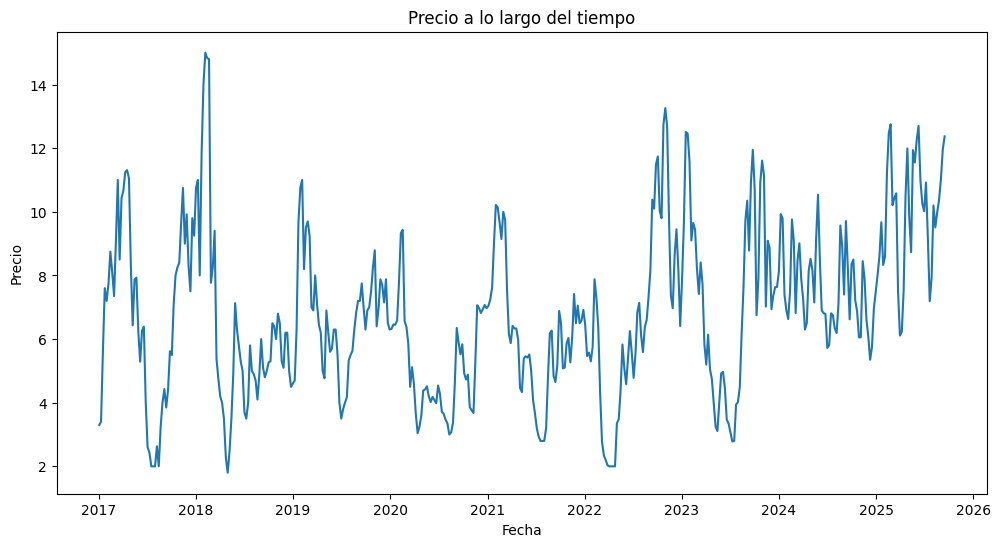

In [41]:
# Patrones temporales - Serie de tiempo de Precio

# Creamos string 'YearWeek' para luego convertirlo en formato fecha
df['YearWeek'] = df['Año'].astype(str) + '-' + df['Semana'].astype(str).str.zfill(2)

try:
    df['Fecha'] = pd.to_datetime(df['YearWeek'] + '-1', format='%Y-%W-%w')
    df = df.set_index('Fecha').sort_index()

    # Mostramos patrones temporales
    plt.figure(figsize=(12, 6))
    plt.plot(df['Precio'])
    plt.title('Precio a lo largo del tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.show()

except Exception as e:
    print(f"Could not create datetime index. Error: {e}")
    print("Temporal plots are shown using index instead.")



**Detección de outliers mediante Z-Score**

In [42]:
# Calcular el Z-score para la columna 'Precio'
df['Precio_Zscore'] = np.abs(zscore(df['Precio'].dropna()))

# Definir umbral de 3 desviaciones estándar
umbral_zscore = 3

# Identificar los outliers
outliers_zscore = df[df['Precio_Zscore'] > umbral_zscore]

print(f"\nIdentificación de Outliers para 'Precio' (usando Z-score con umbral {umbral_zscore}):")

if not outliers_zscore.empty:
    print("\nOutliers encontrados:")
    display(outliers_zscore)
else:
    print("\nNo se encontraron outliers.")

# Opcional: Eliminar la columna de Z-score si no se necesita más
# df = df.drop('Precio_Zscore', axis=1)




Identificación de Outliers para 'Precio' (usando Z-score con umbral 3):

Outliers encontrados:


,Año,Semana,Precio,YearWeek,Precio_Zscore
Fecha,,,,,
2018-02-05,2018,6,15.00,2018-06,3.137064
2018-02-12,2018,7,14.83,2018-07,3.071761
2018-02-19,2018,8,14.80,2018-08,3.060237


**Inconsistencia en los datos**

In [49]:
# Buscamos inconsistencias (parcialmente hecho en describe)
# Buscamos filas duplicadas
print("\nNúmero de filas duplicadas:")
print(df.duplicated().sum())

# Contamos cuantas semanas hay en cada año
print("\nConteo de valores por Año:")
print(df['Año'].value_counts().sort_index())

# Contamos cuantas veces apareció la semana
conteo_semanas = df['Semana'].value_counts()
print("\nConteo de valores por Semana:")

print(conteo_semanas.sort_index().head())
print(conteo_semanas.sort_index().tail())

# Contamos cuántas veces aparece cada frecuencia
frecuencia_de_frecuencias = conteo_semanas.value_counts().sort_index()

print("\nResumen de aparición de semanas:")
for frecuencia, cantidad in frecuencia_de_frecuencias.items():
    print(f"  • {cantidad} semanas aparecen {frecuencia} veces")




Número de filas duplicadas:
0

Conteo de valores por Año:
Año
2017    52
2018    52
2019    52
2020    52
2021    52
2022    52
2023    52
2024    52
2025    37
Name: count, dtype: int64

Conteo de valores por Semana:
Semana
1    9
2    9
3    9
4    9
5    9
Name: count, dtype: int64
Semana
48    8
49    8
50    8
51    8
52    8
Name: count, dtype: int64

Resumen de aparición de semanas:
  • 15 semanas aparecen 8 veces
  • 37 semanas aparecen 9 veces


# 6. Conclusiones e insights

## **Hallazgos principales**

Los valores en el dataset presentan estacionalidad marcada (fluctuaciones recurrentes a lo largo del año), influida por clima y demanda internacional.

Se observaron tendencias de largo plazo, con ciclos de incremento y descenso de precios en periodos de 12–18 meses.

Existen outliers y valores atípicos que corresponden a eventos específicos (shocks logísticos, climáticos o de mercado).

La distribución de precios mostró asimetría (skewness) positiva y colas pesadas, lo que sugiere que no es estrictamente normal.

## **Implicaciones para el modelo de IA**

Modelos tradicionales (ARIMA, SARIMA, ETS) pueden capturar estacionalidad, pero presentan limitaciones ante choques abruptos o no lineales.

Los hallazgos refuerzan la necesidad de un modelo híbrido IA + estadístico, capaz de combinar patrones históricos con detección de anomalías y señales externas.

La no normalidad de los datos implica que métricas basadas en supuestos gaussianos pueden no ser óptimas, favoreciendo enfoques robustos (e.g., Random Forest Regressor, LSTM, Prophet híbrido).

## **Recomendaciones de preprocesamiento**

Tratamiento de outliers: aplicar Winsorizing antes del modelado.

Transformaciones: aplicar log-transform o Box-Cox para estabilizar la varianza.

Generación de features:

*   Variables de calendario (mes, semana, feriados).
*   Lags y moving averages para capturar autocorrelación.
*   Variables externas (clima, costos logísticos, tipo de cambio).

Escalado de datos: normalización o estandarización para algoritmos sensibles a magnitudes.

## **Próximos pasos**

Validación de la serie temporal: dividir en train/validation/test con técnica de time series split (no random).

Prototipo de modelos: comparar ARIMA/SARIMA vs. LSTM/Prophet y modelos híbridos.

Evaluación de métricas: usar RMSE, MAPE y métricas robustas a outliers.

Implementación de pipeline automatizado que permita actualización semanal del modelo con nuevos datos.

Incorporación de variables externas (climáticas y de comercio internacional) para mejorar capacidad predictiva.